# Continued introduction to NCrystal

In this second introductory notebook we continue he introduction to NCrystal by briefly touching upon a few subjects that might not be of direct use for all NCrystal users, but could be beneficial to be aware of.

## Preamble ##
Fix dependencies and tune jupyter a bit. Feel free to replace as you wish:

In [1]:
#Optionally install dependencies via pip. The default is to do this only
#on Google Colab, but you can modify the next line to do it always:
always_do_pip_installs = False # Set to True to enable outside Google Colab
import os
if always_do_pip_installs or os.environ.get("COLAB_RELEASE_TAG"):
    %pip -q install ncrystal ipympl numpy matplotlib

In [2]:
#enable inline matplotlib plots:
if os.environ.get("COLAB_RELEASE_TAG"):
  print("Google Colab detected, matplotlib plots will not be interactive")
  %matplotlib inline
  import matplotlib
  matplotlib.rcParams.update({"figure.autolayout": True})
else:
  print("Enabling interactive matplotlib plots (requires ipympl installed)")
  %matplotlib ipympl
  import matplotlib
  matplotlib.rcParams.update({"figure.figsize":(6.4*0.5,4.8*0.5),
                              "figure.dpi":150,
                              'font.size':5,
                              "figure.autolayout": True})

Enabling interactive matplotlib plots (requires ipympl installed)


In [3]:
%%html
<style>div.jupyter-widgets.widget-label {display: none;}</style>

Always import NCrystal of course:

In [4]:
import NCrystal as NC
assert NC.version_num >=  3009003
NC.test() #< quick unit test that installation works!

Tests completed succesfully


## Single crystal materials
NCrystal supports both isotropic and anisotropic materials. Currently, the only anisotropic models shipped with NCrystal are mosaic single crystals. One is a more generally useful model of Gaussian mosaicity, and the other one is a dedicated one needed to support the special rotated distribution found in pyrolytic graphite (PG). The PG model is automatically enabled when the relevant data file (`C_sg194_pyrolytic_graphite.ncmat`) is used as a single crystal (if not used as a single crystal, it can be used as standard graphite).

Technically, single crystal models are enabled by supplying the material with a mosaic spread (FWHM of the Gaussian mosaicity), and an orientation. The orientation must be specified by providing the coordinates of two vectors in both the crystal space (i.e. the unit cell coordinate system), and the "lab" space (i.e. where the neutron direction is defined). Specifically, we always need the `dir1`, `dir2`, and `mos` to be set, and there are a few other parameters that one might use to fine-tune the models. As always, see the documentation at https://github.com/mctools/ncrystal/wiki/CfgRefDoc .

NCrystal does not provide a simple utility to quickly plot cross sections for anisotropic materials, since the cross sections in general depend on both neutron energy and direction. However, for the case of single crystals used as monochromators, one will often generate *rocking curves*, showing a neutron cross section as a function of incidence angle. If you execute the next code cell below, you will be able to study various monochromator profiles (and then click to the left of the code cell to collapse it and hide the actual code, unless you have a specific interest).

As we can see, the assumption that a monochromator can always be described by a simplistic gaussian is not always very good - especially for neutrons at shorter wavelengths or in monochromators with higher mosaic spreads. Although it should in fairness be noted, that a real monochromator often is accompanied by some sort of angular selection (e.g. a collimator), which makes the plots below appear worse than they are. Still, single crystals can indeed be said to provide rather complicated and interesting cross sections!!

In [5]:
#
# The code in this cell is very long. You are only meant to study it if you
# have a very specific interest in using single crystals, otherwise you should
# simply click on the left to collapse the cell, and instead play with the resulting
# interactive widget!
#
def get_rocking_curve_of_monochromator( *, dataname, hkl, mosaicity_degree, neutron_wl,
                                        only_selected_plane, absorption ):
    """Extract the rocking curve as (delta_angle,xsect), of the given monochromator. We
    assume the give HKL plane has it's normal orthogonal to the monochromator surface, and
    call that the Z axis. If only_selected_plane=True, the curve will have no contributions
    from other planes or non-Bragg physics."""

    import numpy as np
    #Due to the directional parameters, cfg-strings can get a bit longer than usual when
    #specifying single crystal orientations. Here we first put the material and specify
    #the mosaic spread:
    
    cfgstr = f'{dataname};mos={mosaicity_degree}deg'
    #Let us first put the chosen normal along the Z-axis in the lab:
    cfgstr += ';dir1=@crys_hkl:%i,%i,%i@lab:0,0,1'%hkl
    
    #To completely fix the orientation, we need to provide a second direction as well.
    #For this example we don't care, so we will simply provide a dummy direction. If
    #we specify dirtol=180degrees, then we are effectively telling NCrystal to not
    #complain when it discovers that the angle between dir1 and dir2 is not the same
    #in the crystal and lab systems. Instead NCrystal will instead modify dir2 to a
    #consistent value. Only requirement for this to work is that the dir2 and dir1
    #directions are not parallel. In this simple example function we accomplish
    #that by putting in some silly values:
    cfgstr += ';dir2=@crys_hkl:0.134,0.456,0.6789@lab:0.134,0.456,0.6789'
    cfgstr += ';dirtol=180deg'

    #To figure out the ideal wavelength, we need to know the d-spacing of the chosen
    #reflection plane. Naturally, NCrystal is ready to help:
    d_hkl = NC.createInfo(cfgstr).dspacingFromHKL(*hkl)

    #print(f"Focusing on hkl={hkl} in {filename} with d_hkl={d_hkl:.14g} and neutron wl={neutron_wl}Aa")
    if not neutron_wl < 2*d_hkl:
        print(f'Bragg diffraction on selected plane not possible since neutron_wl>2*d_hkl={2*d_hkl}Å')
        return
    
    if only_selected_plane:
        #Disable other physics, and remove planes not
        #in a narrow range around the selected hkl:
        cfgstr += ';comp=bragg'
        cfgstr += f';dcutoff={(1-1e-9)*d_hkl}'
        cfgstr += f';dcutoffup={(1+1e-9)*d_hkl}'
    
    #print(''.join(cfgstr.splitlines()))
    mat = NC.load(cfgstr)
    selectedhkl = []
    if only_selected_plane:
        for e in mat.info.hklList(all_indices=True):
            selectedhkl += [(h,k,l) for h,k,l in zip(e[0],e[1],e[2])]

    import numpy as np
    mosaicity = mosaicity_degree*np.pi/180.;
    thetabragg = np.arcsin( neutron_wl/(2*d_hkl) )
    def xs_of_rocking_angle(rocking_angle):
        th = thetabragg + rocking_angle
        return mat.scatter.xsect( direction=(np.cos(th),0.0,np.sin(th)), wl=neutron_wl)
    rocking_angles = np.linspace(-mosaicity*10,mosaicity*10,1000)
    xs = np.vectorize(xs_of_rocking_angle)(rocking_angles)
    if absorption:
        xs += mat.absorption.xsect(wl=neutron_wl)
    return dict(curve= ((rocking_angles+thetabragg)*180/np.pi,xs),
                hkl=selectedhkl,
                cfgstr=cfgstr,
                dhkl=d_hkl)
    
materials =[('Ge_sg227.ncmat',((1,1,1),(1,1,3),(1,1,5),(3,3,5))),
            ('C_sg194_pyrolytic_graphite.ncmat',((0,0,2),(0,0,4),(0,0,6),(0,0,8))),
            ('Si_sg227.ncmat',((1,1,1),)),
            ('Cu_sg225.ncmat',((1,1,1),(2,2,2),))]

choices=[]
for name,hkls in materials:
    for hkl in hkls:
        choices.append('hkl=%i%i%i %s'%(*hkl,name))
        
from ipywidgets import interact
@interact(mode=choices,
          mosaicity=['0.001 degree','0.1 degree','0.5 degree'],
          neutron_wavelength=['0.8Å','1.8Å','6Å'])
def plot_rocking_curve(mode='',mosaicity='0.1 degree',neutron_wavelength='1.8Å'):
    import matplotlib.pyplot as plt
    plt.figure('sc_rocking_curve')
    plt.clf()
    neutron_wl=float(neutron_wavelength[:-1])
    dataname=mode.split()[1]
    h,k,l=(int(e) for e in mode.split()[0].split('=')[1])
    curve = lambda osp,absn : get_rocking_curve_of_monochromator( dataname=dataname,
                                                             hkl = (h,k,l),
                                                             mosaicity_degree=float(mosaicity.split()[0]),
                                                             neutron_wl=neutron_wl,
                                                             only_selected_plane = osp,
                                                             absorption = absn)
    
    
    c = curve(True,False)
    if not c:
        return
    plt.plot(*c['curve'],label=f'{len(c["hkl"])*2} selected planes with selected d-spacig')
    c_std = curve(False,False)
    plt.plot(*c_std['curve'],label='+Other scattering')
    plt.plot(*curve(False,True)['curve'],label='+Absorption',ls='--',lw=2)
    plt.grid()
    plt.xlabel('Rocking angle (degree)')
    plt.ylabel('cross section (barn)')
    plt.title(mode.replace('.ncmat',''))
    plt.legend()
    plt.show()
    sp = ') ('.join('%i,%i,%i'%p for p in c['hkl'])
    import textwrap
    l=textwrap.wrap('(%s)'%sp,50)
    print('-'*60)
    print('Cfg-string: "%s"'%c_std['cfgstr'])
    print('d-spacing: "%g Å"'%c_std['dhkl'])
    print('Selected planes: %s'%l[0])
    for e in l[1:]:
        print('                 %s'%e)

interactive(children=(Dropdown(description='mode', options=('hkl=111 Ge_sg227.ncmat', 'hkl=113 Ge_sg227.ncmat'…

## Estimating multiple scattering effects with NCrystal's MiniMC
Effects of geometry and multiple scattering is normally something that appears when NCrystal is used with a suitable frontend like McStas, OpenMC, or Geant4. The frontend application keeps track of neutron trajectories and fluxes as they propagate around in a particular geometry. However, NCrystal 3.9.0 introduced a small "MiniMC" frontend, in which neutrons are propagated through a single convex volume (for now just a sphere), and recorded as they come out. For now, the only source available is a monochromatic pencil beam and the only tally available is a 4pi detector showing the exit angle w.r.t. the incoming angle.

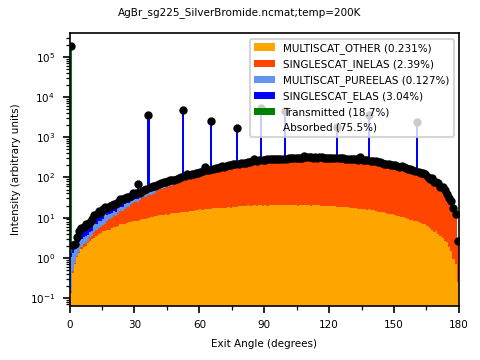

In [6]:
import NCrystal._mmc as ncmmc
pattern = ncmmc.quick_diffraction_pattern('AgBr_sg225_SilverBromide.ncmat;temp=200K',
                                           neutron_energy = '1.8Aa',
                                           material_thickness = '1cm')

pattern.plot_breakdown(rebin_factor=10,logy=True)

Note that you can get this plot same in the terminal by running:
```
nctool --mc 1.8Aa 1cm 'AgBr_sg225_SilverBromide.ncmat;temp=200K'
```
We can try a few more patterns for fun, including some single crystals:

In [7]:
def show_mmc(cfgstr,e,t,log=True):
    pattern = ncmmc.quick_diffraction_pattern( cfgstr, neutron_energy = e, material_thickness = t )
    pattern.plot_breakdown(rebin_factor=10,logy=log)

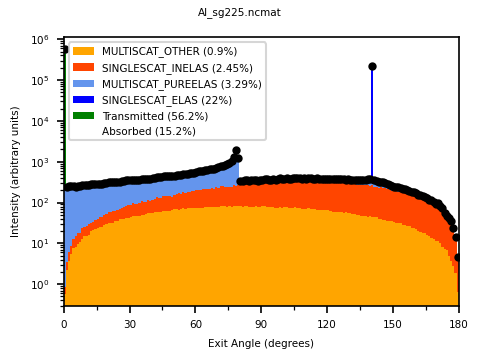

In [8]:
show_mmc('Al_sg225.ncmat','4.4Aa','5cm')#single Bragg edge here

NCrystal WARNING: Discarding 52 edges of provided kernel data due to missing S values.


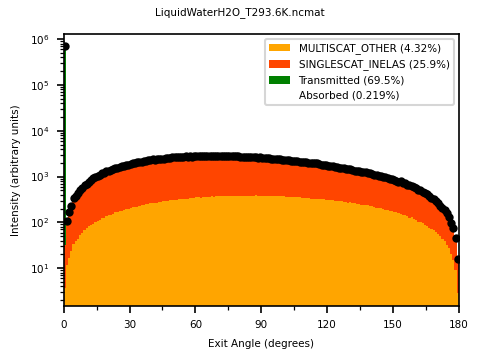

In [9]:
show_mmc('LiquidWaterH2O_T293.6K.ncmat','25meV','1mm')

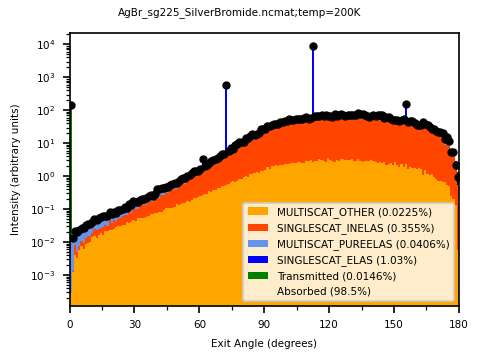

In [10]:
show_mmc('AgBr_sg225_SilverBromide.ncmat;temp=200K','3.4Aa','3cm')#absorbing, suppressing fwd transmission

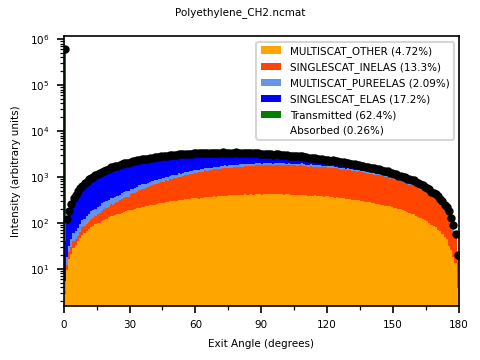

In [11]:
show_mmc('Polyethylene_CH2.ncmat','25meV','1mm')#incoherent elastic is emitted mostly forward

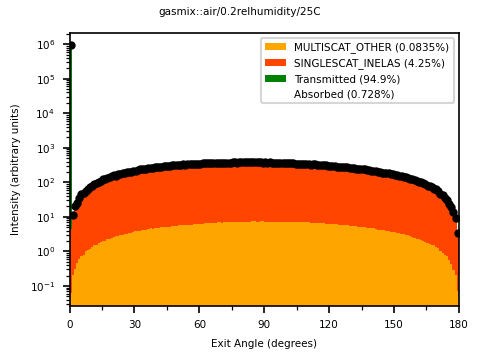

In [12]:
show_mmc('gasmix::air/0.2relhumidity/25C','25meV','1meter')

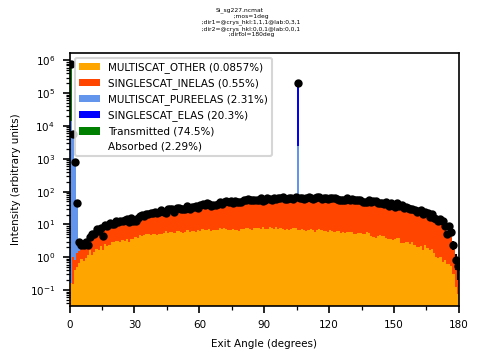

In [13]:
show_mmc('''Si_sg227.ncmat
            ;mos=1deg
            ;dir1=@crys_hkl:1,1,1@lab:0,3,1
            ;dir2=@crys_hkl:0,0,1@lab:0,0,1
            ;dirtol=180deg''','5.0Aa','1cm')#notice zig-zag walk enhances transmission and reflected peaks

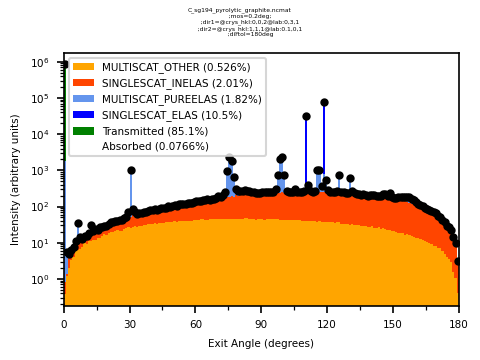

In [14]:
show_mmc('''C_sg194_pyrolytic_graphite.ncmat
           ;mos=0.2deg;
           ;dir1=@crys_hkl:0,0,2@lab:0,3,1
           ;dir2=@crys_hkl:1,1,1@lab:0.1,0,1
           ;dirtol=180deg''','3.5Aa','1cm')

## Easy creation of NCMAT files for hydrogen-rich amorphous materials

Although not yet nicely integrated as part of the Python API, there is a command line tool `ncrystal_hfg2ncmat` which can be easily used to create realistic NCMAT data for any hydrogen-rich amorphous material. See more at https://github.com/mctools/ncrystal/wiki/Announcement-Release2.7.0#tool-for-easy-creation-of-ncmat-files-for-hydrogen-rich-amorphous-materials . The tool is based on a phonon density curve analysis done in:

> ["Thermal neutron cross sections of amino acids from average contributions of functional groups", G. Romanelli, et. al., J. Phys.: Condens. Matter, (2021). doi:10.1088/1361-648X/abfc13](https://doi.org/10.1088/1361-648X/abfc13)

So for instance if you wish to create a file for polystyrene you must read the command `--help` text and try to figure out how the hydrogen atoms are bound in the structure:

![ncrystal_hfg2ncmat](https://raw.githubusercontent.com/wiki/mctools/ncrystal/Announcement-Release2.7.0/Announcement-Release2.7.0_hfg2ncmat.png)

In [15]:
!ncrystal_hfg2ncmat --help

usage: ncrystal_hfg2ncmat [-h] [--output OUTPUT] [--force] --spec SPEC
                          --formula FORMULA --density DENSITY
                          [--debyetemp VALUE] --title TITLE [--notrim]

Script which can be used to generate NCMAT files for hydrogen-rich amorphous
materials, in which the hydrogen atoms are bound to certain standard functional
groups (e.g. carbohydrates, polyimides, polymers, ...). Based on the material's
density, (empirical) chemical formula, and the specification of hydrogen
bindings in terms of standard functional groups, an NCMAT file is generated. In
this NCMAT file, non-hydrogen atoms are treated with a simplistic model
(idealised Debye model of phonon vibrations, assuming a Debye temperature of
400.0K for all atoms unless --debyetemp is specified), and the hydrogen atoms
are treated with a proper phonon density of state (VDOS) curve, which is
constructed based on the provided binding specifications. This is done using an
idea (and VDOS curves fro

In [16]:
# NB: Using --force to avoid errors about 'output file already exists' if rerunning cells:
!ncrystal_hfg2ncmat --formula C8H8 --spec 5xCHaro+1xCHali+1xCH2 --density 0.99 --title polystyrene -o polystyrene.ncmat --force 

Generated NCMAT data...
Verifying that it can be loaded with NCrystal...
Succesfully loaded...
Contribution breakdown based on composition:
  Contribution to bound scattering XS from H (incoherent) is 91.65 %
  Contribution to bound scattering XS from C (coherent)   is  6.34 %
  Contribution to bound scattering XS from H (coherent)   is  2.01 %
  Contribution to bound scattering XS from C (incoherent) is  0.00 %
Wrote: polystyrene.ncmat


In [17]:
import pathlib
print( pathlib.Path('./polystyrene.ncmat').read_text() )

NCMAT v5
#
# polystyrene
#
# ----------------------------------------------------------------------------
#
# File generated by ncrystal_hfg2ncmat with:
#
#  --spec=5xCHaro+1xCHali+1xCH2
#  --formula=C8H8
#  --density=0.99
#
# The hydrogen VDOS curve in this file is constructed using data from:
#
#   "Thermal neutron cross sections of amino acids from average contributions
#   of functional groups", G. Romanelli, et. al., J. Phys.: Condens. Matter,
#   (2021). doi:10.1088/1361-648X/abfc13
#
# Considering only scat. lengths and composition, incoherent scattering on
# hydrogen accounts for 91.7% of scattering in this material (a higher value
# implies more accurate modelling).
#
@STATEOFMATTER
  solid
@DENSITY
  0.99 g_per_cm3
@DYNINFO
  element C
  fraction 8/16
  type vdosdebye
  debye_temp 400.0
@DYNINFO
  element  H
  fraction 8/16
  type     vdos
  vdos_egrid 0.00360721 0.434669
  vdos_density .0334822 .05309 .0779554 .101056 .120488 .134777 .132918 .1223
   .116246 .114615 .101842 

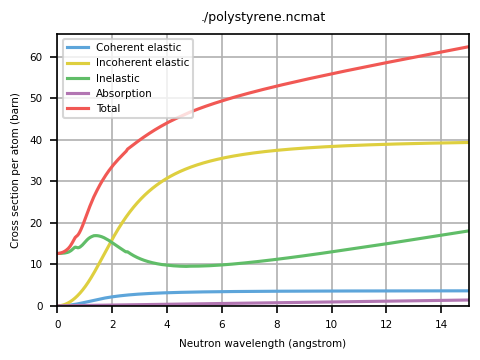

In [18]:
import NCrystal.plot as ncplot
ncplot.plot_xsect('./polystyrene.ncmat')

## Using NCrystal with other codes.
Although not directly related to the Python API of NCrystal, we anyway take the opportunity to provide a small overview of some of the frontends that you can currently use with NCrystal. This is after all in all likelihood the primary reason most NCrystal users care about NCrystal.

### OpenMC
Using NCrystal materials in openmc is supported since OpenMC release 13.3, and uses a nice simple syntax in the Python API (see also https://docs.openmc.org/en/stable/usersguide/materials.html#adding-ncrystal-materials):

```
mat = openmc.Material.from_ncrystal('Polyethylene_CH2.ncmat;temp=50C')
```

which when used in a complete OpenMC project, results in the following material entry being added to the `materials.xml` produced:

```
  <material cfg="Polyethylene_CH2.ncmat;temp=50C" id="1" temperature="323.15">
    <density units="g/cm3" value="0.92" />
    <nuclide ao="0.66656284" name="H1" />
    <nuclide ao="0.00010382666666666666" name="H2" />
    <nuclide ao="0.32964066666666664" name="C12" />
    <nuclide ao="0.003692666666666666" name="C13" />
  </material>
```

Temperature, density and material composition were all created automatically from the cfg-string, and the cfg-string itself was also encoded. Upon launching the simulation with the OpenMC binary executable `openmc`, it will handle the material as usual, except that low-energy neutron scattering physics (currently defined as ($E<5eV$) will be provided by the algorithms in NCrystal.

A few issues might warrent attention:

1. If you try to assemble the above xml manually, it is rather unlikely that you will get the base densities and compositions right. It is safest to stick to let the Python API compose the xml for you.
2. After creation with `mat=openmc.Material.from_ncrystal(..)`, you can not use the usual OpenMC API to modify the material density, temperature, or composition. So be sure to reflect the final desired material inside the NCrystal cfg-string.
3. The OpenMC binaries must have been built with NCrystal support, or your job will fail once you launch the simulation (you can check for this by running the command `openmc -v`). Specifically (as documented on https://docs.openmc.org/en/stable/usersguide/install.html) you must supply the CMake flag
`cmake -DOPENMC_USE_NCRYSTAL=on ..` (and make sure NCrystal is available already).
Note: we have agreement from OpenMC developers to enable NCrystal support by default in the conda-forge version of OpenMC. So in "the near future" (summer/fall 2023) conda users will always have NCrystal support available in OpenMC.

For reference, here is a complete small example of an OpenMC project in Python using NCrystal. We are not actually running it by default, since not everyone using the notebook might have access to OpenMC:

In [19]:
if False:
    import openmc
    # Materials
    openmc_mat = openmc.Material.from_ncrystal('Polyethylene_CH2.ncmat;temp=50C')
    # Geometry
    s1 = openmc.Sphere(r=10, boundary_type='vacuum')
    c1 = openmc.Cell(region=-s1, fill=openmc_mat)
    geometry = openmc.Geometry([c1])
    # Execution settings
    settings = openmc.Settings()
    settings.source = openmc.Source(energy=openmc.stats.Discrete(x=[10.0], p=[1.0]))
    settings.run_mode = 'fixed source'
    settings.batches = 10
    settings.particles = 10000
    # Write xml files
    model = openmc.model.Model(geometry=geometry, settings=settings)
    model.export_to_xml()
    #Check resulting materials.xml (we could of course actually RUN OpenMC here instead)
    import pathlib
    print(pathlib.Path('materials.xml').read_text())

Credits: The OpenMC-NCrystal bindings originated with the NCrystal developers (esp. J.I. Marquez Damian), but were facilitated along the way by useful technical assistance and a welcoming attitude from the OpenMC developers (esp. Paul Romano).

### McStas (incl. Union and McStasScript)

*NOTE: The following discussion concerns the modern McStas 3 branch, and might in particular not be 100% accurate for releases earlier than McStas 3.3 (probably OK for v3.2 though).*

You can use NCrystal in two ways in McStas. You can either use it for advanced studies with the McStas Union sub-system through the NCrystal_process component, or it can be used via the dedicated (and simpler+less feature-rich) NCrystal_sample.comp. In any case, the McStas instrument file compilation will need to build against NCrystal, and it uses the ncrystal-config command to figure out the correct settings for doing so. Thus, you can always invoke `ncrystal-config -s` to find out if you have the right NCrystal installation available and active. It is currently the case (May, 2023) that most McStas users will find that NCrystal has already been installed as part of their McStas installation, albeit there might be a need to activate the NCrystal installation by invoking (the script might at some point in the future be renamed ncrystal-setup.sh or similar):
```
   $> . $MCSTAS/setup.sh
```
It is beyond the scope for this notebook to provide a full documentation of McStas, or the Union sub-system, but if you are using McStasScript to compose your instruments, you can add NCrystal materials into your Union geometry using code like:
```
  from mcstasscript.tools.ncrystal_union import add_ncrystal_union_material
  add_ncrystal_union_material(instr, name="myAl", cfgstr="Al_sg225.ncmat;temp=10C")
```
This creates the material and gives it the name `"myAl"`, which you must later attach to a particular Union volume, like for instance:
```
  myvol.set_parameters(radius=0.01, yheight=0.01,
                       material_string='"myAl"', priority=1)
```
If you are instead hand-editing your instrument files, you can generate code which defines Union materials from an NCrystal cfg-string by invoking:

In [20]:
!python3 -mNCrystal.mcstasutils --union myAl 'Al_sg225.ncmat;temp=250K'


/*
   The following code was auto generated by NCrystal v3.9.3 via Python:

     NCrystal.mcstasutils.cfgstr_2_union_instrument_code(
         cfgstr = 'Al_sg225.ncmat;temp=250K',
         name = 'myAl' )

   Please rerun in case of major changes to input data or NCrystal.
*/

COMPONENT myAl_ncrystal_proc = NCrystal_process(
    cfg = "Al_sg225.ncmat;temp=250" )
AT (0,0,0) ABSOLUTE

COMPONENT myAl = Union_make_material(
    process_string = "myAl_ncrystal_proc",
    my_absorption = 1.39136803716641 )
AT (0,0,0) ABSOLUTE

/* End of auto generated code from NCrystal v3.9.3. */



Or you can add `--split` to investigate by physics type:

In [21]:
!python3 -mNCrystal.mcstasutils --union myAl 'Al_sg225.ncmat;temp=250K' --split


/*
   The following code was auto generated by NCrystal v3.9.3 via Python:

     NCrystal.mcstasutils.cfgstr_2_union_instrument_code(
         cfgstr = 'Al_sg225.ncmat;temp=250K',
         name = 'myAl',
         split_by_physics = True )

   Please rerun in case of major changes to input data or NCrystal.
*/

COMPONENT myAl_ncrystal_cohelas_proc = NCrystal_process(
    cfg = "Al_sg225.ncmat;incoh_elas=0;inelas=0;sans=0;temp=250" )
AT (0,0,0) ABSOLUTE

COMPONENT myAl_ncrystal_incohelas_proc = NCrystal_process(
    cfg = "Al_sg225.ncmat;coh_elas=0;inelas=0;sans=0;temp=250" )
AT (0,0,0) ABSOLUTE

COMPONENT myAl_ncrystal_inelas_proc = NCrystal_process(
    cfg = "Al_sg225.ncmat;coh_elas=0;incoh_elas=0;sans=0;temp=250" )
AT (0,0,0) ABSOLUTE

COMPONENT myAl = Union_make_material(
    process_string = "myAl_ncrystal_cohelas_proc,myAl_ncrystal_incohelas_proc,myAl_ncrystal_inelas_proc",
    my_absorption = 1.39136803716641 )
AT (0,0,0) ABSOLUTE

/* End of auto generated code from NCrystal v3.

It should be noted that McStas 3.3 also provides a new `SHELL` syntax which can also be used to faciliate this invocation from with a classic .instr file. Its usage can bee seen in the following example

```
DEFINE INSTRUMENT example2()
SHELL "PYTHONPATH=$MCSTAS/share/NCrystal/python/ python3 -mNCrystal.mcstasutils --union --split myMaterial_Al 'phases<0.01*void.ncmat&0.99*Al_sg225.ncmat;temp=200K>' > materials_snippet.instr"
TRACE
COMPONENT init = Union_init()
AT (0,0,0) ABSOLUTE
%include "materials_snippet.instr"
COMPONENT origin = Progress_bar()
  AT (0, 0, 0) RELATIVE ABSOLUTE
COMPONENT source =   Source_div(lambda0=1.539739, dlambda=0.01, xwidth=0.001, yheight=0.001, focus_aw=1, focus_ah=1)
  AT (0, 0, 0.3) RELATIVE origin
COMPONENT powder_sample = Union_cylinder(yheight=0.01, radius=0.01, priority=1, material_string="myMaterial_Al")
AT (0, 0, 1) RELATIVE origin
COMPONENT master2 = Union_master()
AT (0, 0, 0) RELATIVE powder_sample
COMPONENT powder_pattern_detc = Monitor_nD(
    options = "banana, angle limits=[10 170], bins=500",
    radius = 0.05, yheight = 0.1)
  AT (0, 0, 0) RELATIVE powder_sample
COMPONENT stop = Union_stop()
AT (0,0,0) ABSOLUTE
END
```

On the other hand, the dedicated NCrystal_sample.comp component, embeds NCrystal material simulations into simple shapes (currently boxes, cylinders and spheres), and can be used for components representing samples, filters or monochromators, entrance windows, etc. The component is since McStas v3.3 part of the McStas release itself, and can be used in a .instr file - for instance if you wish to set up an r=1cm sphere with powdered sapphire you would write:
```
COMPONENT mysample = NCrystal_sample(cfg="Al2O3_sg167_Corundum.ncmat",radius=0.01)
AT (0, 0, 0) RELATIVE PREVIOUS
```
For more documentation about the NCrystal_sample component, run:
```
$> mcdoc NCrystal_sample
```
Or consult the documentation online at https://www.mcstas.org/download/components/

*Credits: The integration into McStas, Union, and McStasScript is largely a result of efforts by Peter Willendrup and Mads Bertelsen working in close collaboration with the NCrystal developers.*

### Geant4

Geant4-bindings allow NCrystal cfg-strings to be used directly in Geant4 material creation code, through the usage of specific helper functions:

```
//Include the relevant header:
#include "G4NCrystal/G4NCrystal.hh"

//...

//Create materials directly from cfg-strings:
G4Material * mat_aluminium = G4NCrystal::createMaterial("Al_sg225.ncmat");

//...

//Currently the NCrystal process must then be injected in the following way:

g4runManager->Initialize();
G4NCrystal::installOnDemand();
g4runManager->BeamOn(1000);
```
The last part about injecting a specific NCrystal process is a bit of a technical workaround, and the NCrystal developers are in contact with the Geant4 Hadronic working group (in particular thanks to Alberto Ribbon) about a better solution. But it works for now in non-multithreaded Geant4.

For a fully fledged example, see:

https://github.com/mctools/ncrystal/blob/master/examples/ncrystal_example_g4sim.cc

### Others

While OpenMC, Geant4, and McStas are currently the best known and supported frameworks, other emerging applications are currently integrated with NCrystal, including the Cinema framework from CSNS (Xiao Xiao Cai, et. al.), [ANTS2](https://github.com/andrmor/ANTS2) from LIP-Coimbra (Andrei Morozov, et. al.), and [TOUCANS](https://doi.org/10.1016/j.nima.2023.168190) from CEA (Loïc Thulliez, et. al.).

It is also possibly to benefit partly from NCrystal by using several of the conversion mechanisms we have for creating data-files for other codes. In all cases though, a lot of the physics is lost in the conversion so if at all possible, you should try to use NCrystal directly:
* You can use the `ncrystal_ncmat2hkl` commandline tool to create `.lau` and `.laz` files for various non-NCrystal Bragg diffraction components in McStas.
* You can use the NJOY-NCrystal project to create ENDF files from NCrystal data files, which can then be used in traditional codes like MCNP, etc. For more information see:
  * https://github.com/highness-eu/NJOY-NCrystal-Library
  * K. Ramic, et. al.. "NJOY+NCrystal: an open-source tool for creating thermal neutron scattering libraries"  Nuclear Instruments and Methods in Physics Research Section A: Accelerators, Spectrometers, Detectors and Associated Equipment 1027 (2022) 166227, https://doi.org/10.1016/j.nima.2021.166227
  * J.I. Márquez Damián is working on a more convenient utility which would be able to write ENDF files from NCrystal without needing NJOY (see https://github.com/mctools/ncrystal/issues/183).